# Borys Lypa

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import re

from typing import Union

np.random.seed(17)

%matplotlib inline

In [2]:
import os
if os.getcwd() == '/opt/notebooks':
    df = pd.read_csv('smart_insight/data_housing.csv', index_col=0)
else:
    df = pd.read_csv('data_housing.csv', index_col=0)

In [3]:
df.dtypes

rent       object
dist       object
nrooms    float64
age        object
size       object
noccup     object
price     float64
dtype: object

- **rent**: amount of monthly payment in USD
- **dist**: distance to center 
- **nrooms**: number of rooms 
- **age**: age of house 
- **size**: are in sq.m
- **noccup**: number of people registered in the house
- **price**: price of the house in USD


<AxesSubplot:>

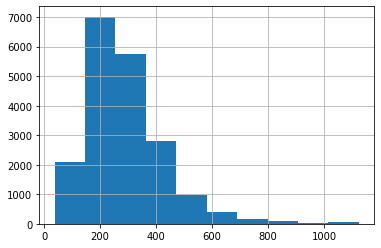

In [4]:
# need to remove quotes from data, and deal with na values
def parse_rent(field: Union[str, float]) -> float:
    if isinstance(field, str):
        return abs(float(field.translate(str.maketrans('', '', '\"\''))))
    if field <= 0:
        return abs(field)
    return field
    
df['rent'].apply(parse_rent).hist()

In [5]:
df['rent'] = df['rent'].apply(parse_rent)

<AxesSubplot:>

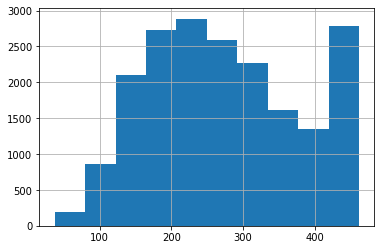

In [6]:
rent_90_quantile = df['rent'].quantile(0.9)
df['rent'] = np.where(df["rent"] > rent_90_quantile, rent_90_quantile, df['rent'])
df['rent'].hist()

In [7]:
dist_parser = {
    'center': 0,
    'close to center': df.loc[pd.to_numeric(df['dist'], errors='coerce').notnull()]['dist'].astype(float).quantile(0.1),
    'far from center': df.loc[pd.to_numeric(df['dist'], errors='coerce').notnull()]['dist'].astype(float).quantile(0.9)
}

<AxesSubplot:>

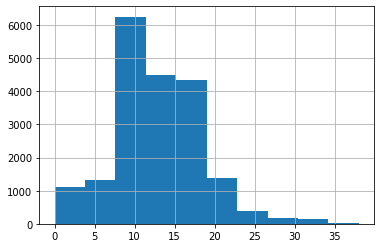

In [8]:
def parse_dist(field: Union[str, int, float]) -> float:
    if isinstance(field, str):
        field = field.translate(str.maketrans('', '', '\"\''))

        if dist_parser.get(field, None) is not None:
            return float(dist_parser[field])

        match = re.findall(r'to center = (\d+)', field)
        if match:
            return float(match[0])

        else:
            return float(field)

    return field

df['dist'].apply(parse_dist).astype(float).hist()

In [9]:
df['dist'] = df['dist'].apply(parse_dist).astype(float)

<AxesSubplot:>

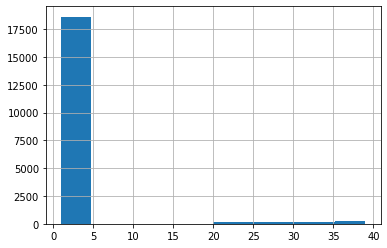

In [10]:
# тут тільки нани and outliers
df['nrooms'].hist()

<AxesSubplot:>

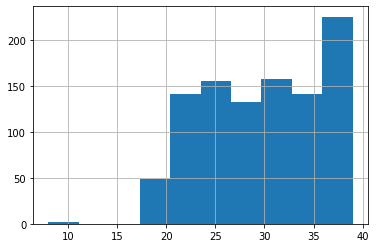

In [11]:
df.loc[df['nrooms'] >= 7]['nrooms'].hist() # idk how many rooms is too many

In [12]:
age_parser = {
    'new': 0,
    'mid': df.loc[pd.to_numeric(df['age'], errors='coerce').notnull()]['age'].astype(float).quantile(0.5),
    'old': df.loc[pd.to_numeric(df['age'], errors='coerce').notnull()]['age'].astype(float).quantile(0.9)
}

<AxesSubplot:>

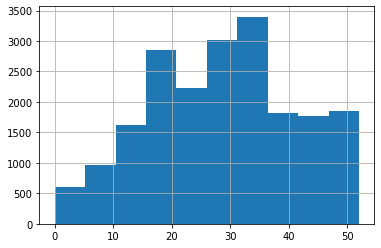

In [13]:
def parse_age(field: Union[str, int]) -> float:
    if isinstance(field, str):
        if age_parser.get(field, None) is not None:
            return float(age_parser[field])

        match = re.findall(r'age:(\d+)', field)
        if match:
            return float(match[0])
        else:
            return float(field)
    return field

df['age'].apply(parse_age).hist()

In [14]:
df['age'] = df['age'].apply(parse_age)

<AxesSubplot:>

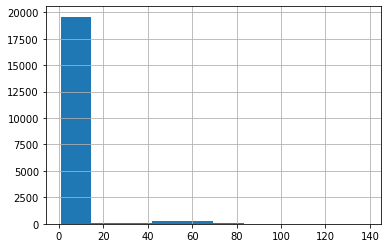

In [15]:
def parse_size(field: Union[str, int]) -> float:
    if isinstance(field, str):
        field = field.translate(str.maketrans('', '', '\"\''))

        match = re.findall(r'size:(\d+)', field)
        if match:
            return match[0]
        
        match = re.findall(r'\'?(\d+).+\'?', field)
        if match:
            return float(match[0])
            
        else:
            return float(field) # I think field mostly are int but there are some '17.0' field that are not getting parsed
    return field

df['size'].apply(parse_size).astype(float).hist()

In [16]:
df['size'] = df['size'].apply(parse_size).astype(float)

<AxesSubplot:>

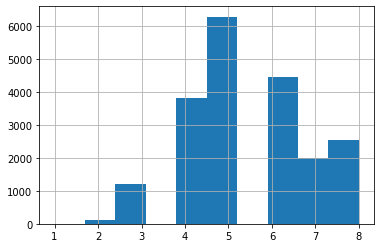

In [17]:
size_90_quantile = df['size'].quantile(0.9)
df['size'] = np.where(df["size"] > size_90_quantile, size_90_quantile, df['size'])
df['size'].hist()

In [18]:
# I dont care about this field atm

from word2number import w2n

def parse_noccup(field: Union[str, float]) -> float:
    if isinstance(field, str):
        try:
            return float(field.translate(str.maketrans('', '', '\"\'')))
        except Exception:
            return w2n.word_to_num(field)
    return float(field)

df['noccup'] = df['noccup'].apply(parse_noccup)

<AxesSubplot:>

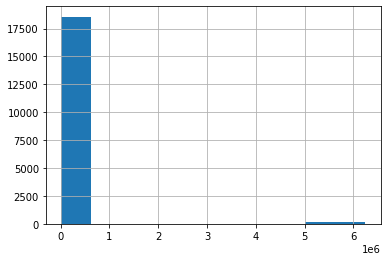

In [19]:
df['price'].hist()

In [20]:
parsed_df = df.copy()

In [81]:
df = parsed_df.copy()
df = df.drop('nrooms', axis=1)
df = df.drop('noccup', axis=1)
# df = df.fillna(0)
df = df.dropna()

In [72]:
from sklearn.impute import SimpleImputer
imp = SimpleImputer()
df = pd.DataFrame(imp.fit_transform(df), columns=df.columns)

In [188]:
from sklearn.preprocessing import StandardScaler
norm = StandardScaler()
df = pd.DataFrame(norm.fit_transform(df), columns=df.columns)

In [82]:
df.describe()

,rent,dist,age,size,price
count,16237.000000,16237.000000,16237.000000,16237.000000,1.623700e+04
mean,275.728891,12.742440,28.718175,5.464679,1.801160e+05
std,107.317886,5.542668,12.687044,1.404446,6.526391e+05
min,37.000000,0.000000,0.000000,1.000000,7.499500e+03
25%,191.000000,10.000000,18.000000,4.000000,6.025000e+04
50%,264.000000,12.000000,29.000000,5.000000,9.055000e+04
75%,355.000000,17.000000,37.000000,6.000000,1.341500e+05
max,462.000000,38.000000,52.000000,8.000000,6.246806e+06


In [83]:
df.dtypes

rent     float64
dist     float64
age      float64
size     float64
price    float64
dtype: object

<AxesSubplot:>

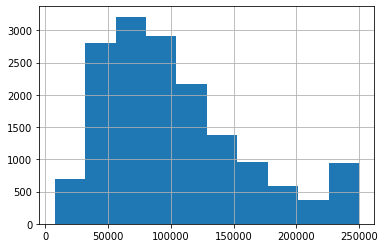

In [84]:
price_95_quantile = df['price'].quantile(0.95)
df.loc[df['price'] <= price_95_quantile]['price'].hist()

In [85]:
from sklearn.model_selection import train_test_split

idk_df = df.copy()

validation_df = parsed_df.loc[parsed_df['price'].isna()].fillna(0)

test_train_df = idk_df.dropna()
test_train_df = test_train_df.loc[idk_df['price'] <= price_95_quantile]

X_train, X_test, y_train, y_test = train_test_split(test_train_df.drop('price', axis=1), test_train_df['price'], test_size=0.2)


In [86]:
test_train_df.describe()

,rent,dist,age,size,price
count,16011.000000,16011.000000,16011.000000,16011.000000,16011.000000
mean,275.653301,12.733933,28.724252,5.465055,103030.885797
std,107.409070,5.545308,12.698142,1.404757,57463.967684
min,37.000000,0.000000,0.000000,1.000000,7499.500000
25%,191.000000,10.000000,18.000000,4.000000,59650.000000
50%,264.000000,12.000000,29.000000,5.000000,89550.000000
75%,354.500000,17.000000,37.000000,6.000000,131950.000000
max,462.000000,38.000000,52.000000,8.000000,250000.500000


In [112]:
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(n_estimators=500, max_depth=10, min_samples_leaf=5, min_samples_split=2, random_state=17)
model = forest.fit(X_train, y_train)
predictions = forest.predict(X_test)

Text(0, 0.5, 'Predictions')

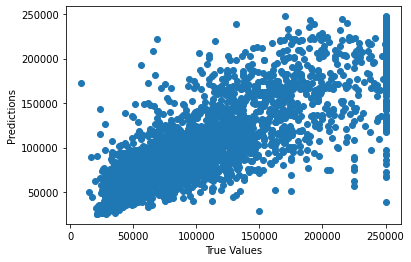

In [113]:
plt.scatter(y_test, predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')

In [114]:
from sklearn.metrics import explained_variance_score
explained_variance_score(y_test, predictions)

0.6455351266461313

In [116]:
print(' '.join([f'{field}:{importance}' for field, importance in zip(X_train.columns, lm.feature_importances_)]))

rent:0.6000096446924894 dist:0.12951174647338057 age:0.15678631366969667 size:0.11369229516443341


In [109]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 500, 1000],
    'max_depth' : [None, 2, 5, 10],
    'min_samples_split': [2, 0.1, 0.01, 10, 20],
    'min_samples_leaf': [1, 0.1, 0.01, 5, 10]
    }

forest = RandomForestRegressor(random_state=17)
gs = GridSearchCV(forest, param_grid)
gs.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestRegressor(random_state=17),
             param_grid={'max_depth': [None, 2, 5, 10],
                         'min_samples_leaf': [1, 0.1, 0.01, 5, 10],
                         'min_samples_split': [2, 0.1, 0.01, 10, 20],
                         'n_estimators': [100, 200, 500, 1000]})

In [110]:
gs.best_params_

{'max_depth': 10,
 'min_samples_leaf': 5,
 'min_samples_split': 2,
 'n_estimators': 500}

In [92]:
validation_df['price'] = forest.predict(validation_df.drop(['price', 'nrooms', 'noccup'], axis=1))
validation_df

,rent,dist,nrooms,age,size,noccup,price
1,462.0,17.0,2.0,21.0,4.0,3.0,203311.300833
5,302.0,17.0,2.0,52.0,4.0,3.0,163379.755000
16,208.0,17.0,2.0,52.0,4.0,3.0,164171.005000
22,129.0,17.0,2.0,52.0,4.0,3.0,68025.500000
24,195.0,17.0,2.0,52.0,4.0,3.0,102313.000000
...,...,...,...,...,...,...,...
20571,256.0,18.0,2.0,6.0,6.0,3.0,67531.000000
20597,158.0,20.0,2.0,33.0,4.0,3.0,40464.000000
20608,0.0,20.0,2.0,24.0,7.0,3.0,31227.470000
20626,162.0,20.0,2.0,36.0,5.0,3.0,35494.500000


In [106]:
result_df = parsed_df.copy()
result_df.loc[validation_df.index] = validation_df
result_df

,rent,dist,nrooms,age,size,noccup,price
0,462.0,17.0,2.0,41.0,5.0,3.0,226300.000000
1,462.0,17.0,2.0,21.0,4.0,3.0,203311.300833
2,462.0,NaN,2.0,52.0,5.0,3.0,176050.000000
3,423.0,17.0,2.0,52.0,5.0,3.0,170650.000000
4,288.0,17.0,2.0,52.0,4.0,3.0,171100.000000
...,...,...,...,...,...,...,...
20635,117.0,20.0,2.0,25.0,5.0,3.0,39050.000000
20636,191.0,20.0,2.0,29.0,6.0,3.0,38550.000000
20637,127.0,NaN,2.0,17.0,4.0,3.0,46150.000000
20638,140.0,20.0,NaN,18.0,4.0,3.0,42350.000000
